In [2]:
import os
import numpy as np
import pandas as pd

from fastai import *
from fastai.vision.all import *
from fastai.metrics import error_rate

### Build a data frame

In [7]:
path_df = './cell_data_annotated.pkl'

In [13]:
# read in the annotated data frame
df = pd.read_pickle(path_df)
df.head()

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,major_axis_length,minor_axis_length,...,local_centroid-1,foci_number,im_frame,cell_name,volume,ann_phase1,ann_phase2,ann_phase3,ann_mis,ann
0,8,194,18.829897,790.170103,11,782,28,799,16.770126,14.757904,...,8.170103,1.0,data_set1_PA_10min_00,data_set1_PA_10min_00_0008,1912.424479,False,False,False,False,NaN
1,9,345,26.046377,728.202899,16,717,36,740,22.599048,19.475703,...,11.202899,0.0,data_set1_PA_10min_00,data_set1_PA_10min_00_0009,4488.229194,True,False,False,False,phase1
2,10,257,27.980545,824.167315,19,815,38,835,19.896883,16.486363,...,9.167315,0.0,data_set1_PA_10min_00,data_set1_PA_10min_00_0010,2831.609620,False,False,False,False,NaN
3,11,431,29.292343,112.341067,18,101,42,124,24.111707,22.787024,...,11.341067,0.0,data_set1_PA_10min_00,data_set1_PA_10min_00_0011,6555.438981,False,False,False,False,NaN
4,12,292,29.140411,404.044521,20,394,39,415,21.145596,17.600479,...,10.044521,0.0,data_set1_PA_10min_00,data_set1_PA_10min_00_0012,3429.790126,False,False,False,False,NaN


In [18]:
# create a training set
data_sel = df.loc[df.ann==df.ann,:]
# cound annotated objects
len(data_sel)

530

In [16]:
def get_x(r): return os.path.join('./singles_01',f'{r["cell_name"]}.tiff')
def get_y(r): return r['ann']

In [19]:
dblock = DataBlock(blocks=(ImageBlock,CategoryBlock),
                   splitter = RandomSplitter(valid_pct=0.2),
                   get_x=get_x,get_y=get_y,
                   batch_tfms = [*aug_transforms(flip_vert=True,max_rotate=60.0,max_zoom=1)])
dsets = dblock.datasets(data_sel)
dls = dblock.dataloaders(data_sel)

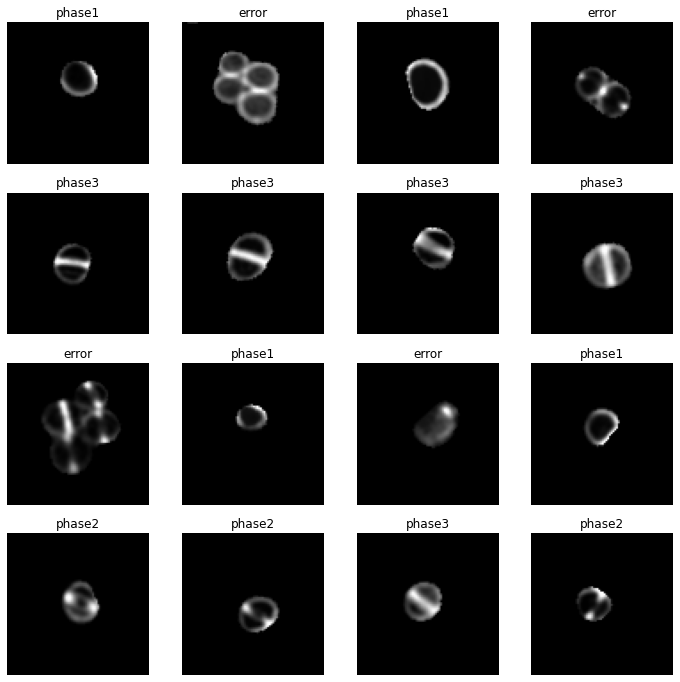

In [20]:
# visualize a batch
dls.show_batch(max_n=16)

In [48]:
# create a learner
learn = cnn_learner(dls, resnet50, metrics=error_rate)

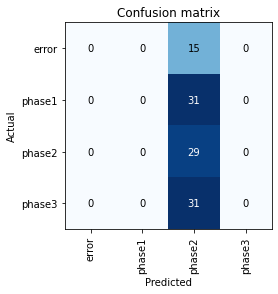

In [49]:
# check initial status of the learner
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))

In [50]:
# freeze early layers
learn.freeze()

SuggestedLRs(valley=0.0004786300996784121)

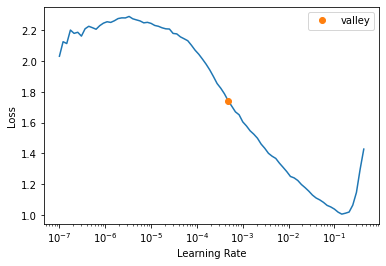

In [51]:
# find starting learning rate
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,2.140300,1.499684,0.641509,00:01
1,1.782004,1.273530,0.528302,00:01
2,1.469321,0.823095,0.301887,00:01
3,1.239097,0.498948,0.169811,00:01
4,1.056027,0.321963,0.094340,00:01
5,0.930346,0.327553,0.094340,00:01
6,0.828894,0.464168,0.169811,00:01
7,0.743331,0.723048,0.216981,00:01
8,0.672583,0.814395,0.216981,00:01
9,0.628662,0.737675,0.235849,00:01


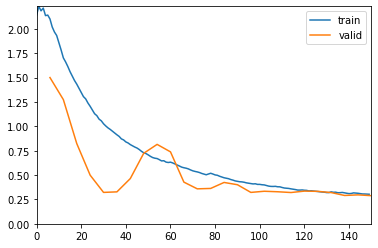

In [52]:
# training
learn.fit_one_cycle(25,0.0005,cbs=[ShowGraphCallback()])

In [53]:
# allow changes for early layers
learn.unfreeze()

SuggestedLRs(valley=0.00010964782268274575)

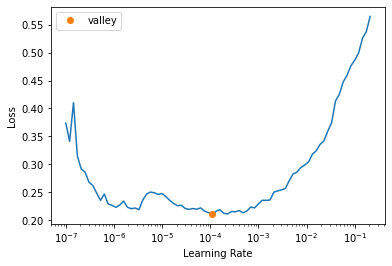

In [54]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time
0,0.167577,0.225459,0.094340,00:01
1,0.182845,0.265238,0.075472,00:01
2,0.220655,0.217603,0.056604,00:01
3,0.227995,0.280523,0.084906,00:01
4,0.259621,1.293824,0.160377,00:01
5,0.255959,0.598932,0.113208,00:01
6,0.257152,0.754203,0.132075,00:01
7,0.267184,0.388239,0.066038,00:01
8,0.244766,0.280095,0.084906,00:01
9,0.228991,0.197880,0.028302,00:01


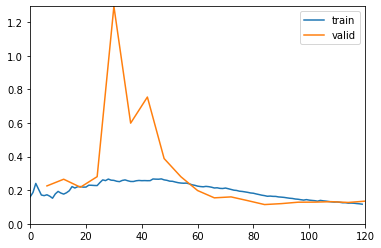

In [55]:
learn.fit_one_cycle(20,3*1e-4,cbs=[ShowGraphCallback()])

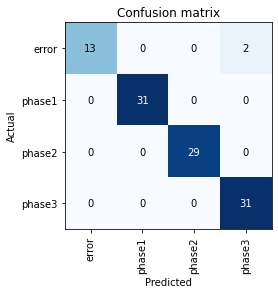

In [56]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))

In [57]:
def plot_top_losses_fix(interp, k, largest=True, **kwargs):
        losses,idx = interp.top_losses(k, largest)
        if not isinstance(interp.inputs, tuple): interp.inputs = (interp.inputs,)
        if isinstance(interp.inputs[0], Tensor): inps = tuple(o[idx] for o in interp.inputs)
        else: inps = interp.dl.create_batch(interp.dl.before_batch([tuple(o[i] for o in interp.inputs) for i in idx]))
        b = inps + tuple(o[idx] for o in (interp.targs if is_listy(interp.targs) else (interp.targs,)))
        x,y,its = interp.dl._pre_show_batch(b, max_n=k)
        b_out = inps + tuple(o[idx] for o in (interp.decoded if is_listy(interp.decoded) else (interp.decoded,)))
        x1,y1,outs = interp.dl._pre_show_batch(b_out, max_n=k)
        if its is not None:
            #plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), L(self.preds).itemgot(idx), losses,  **kwargs)
            plot_top_losses(x, y, its, outs.itemgot(slice(len(inps), None)), interp.preds[idx], losses,  **kwargs)
        #TODO: figure out if this is needed
        #its None means that a batch knows how to show itself as a whole, so we pass x, x1
        #else: show_results(x, x1, its, ctxs=ctxs, max_n=max_n, **kwargs)

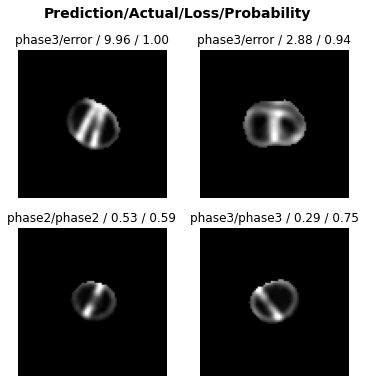

In [58]:
plot_top_losses_fix(interp,4,nrows=2)

In [59]:
learn.save('staphNet_unfreeze_220420')
learn.export('staphNet_unfreeze_220420.pkl')

## Predict for all cells

In [60]:
# check names of categories
v=dsets.vocab
v

['error', 'phase1', 'phase2', 'phase3']

In [61]:
test_files = [get_x(x) for i,x in df.iterrows()]
test_dl = learn.dls.test_dl(test_files)

In [62]:
preds, _, decoded = learn.get_preds(dl=test_dl, with_decoded=True)

In [63]:
len(decoded)

32296

In [64]:
df['nn_phase'] = [v[x] for x in decoded]

In [65]:
df.groupby('nn_phase').count()

,label,area,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,major_axis_length,minor_axis_length,...,local_centroid-1,foci_number,im_frame,cell_name,volume,ann_phase1,ann_phase2,ann_phase3,ann_mis,ann
nn_phase,,,,,,,,,,,,,,,,,,,,,
error,2115,2115,2115,2115,2115,2115,2115,2115,2115,2115,...,2115,2115,2115,2115,2115,2115,2115,2115,2115,78
phase1,18365,18365,18365,18365,18365,18365,18365,18365,18365,18365,...,18365,18365,18365,18365,18365,18365,18365,18365,18365,151
phase2,7666,7666,7666,7666,7666,7666,7666,7666,7666,7666,...,7666,7666,7666,7666,7666,7666,7666,7666,7666,149
phase3,4150,4150,4150,4150,4150,4150,4150,4150,4150,4150,...,4150,4150,4150,4150,4150,4150,4150,4150,4150,152


In [66]:
df.to_pickle('./cell_data_nn.pkl')